# <center>Probabilistic Programming Workflow</center>

## <center>Open Source Tools for Rapid Reproducible Probabilistic Model Development</center>

Objectives:
* Open source tools for replicable science
* Replicable pre-processing pipeline
* Replicable transparent probabilistic models

# <u>Overview</u> 
1. Reproducible Pre-processing
2. Probabilistic Programming

<a id=TOP></a>
# <u>Overview</u>
1. Reproducible Pre-processing
    1. [Loading & Cleaning Data](#load)
    2. [Exogenous Feature Transformations](#exo)
    3. [Data Splitting into Train/Test Sets](#split)
    4. [Endogenous Data Transformation](#endo)
    5. [Preserving the Pre-Processing Pipeline](#pickle) 

2. Probabilistic Programming

1. Reproducible Pre-processing

2. Probabilistic Programming
    1. [A Quick Primer](#primer)
    2. [Models for Approximating Data Generating Process](#pymc3)
    3. [Priors for Context-Aware Models](#priors)
    4. [Fitting Data, Model Evaluation, Model Comparison](#fiteval)
    5. [Conclusion](#conclusion)

In [1]:
# STL
import pickle

# numerical libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# graphic facilities
import matplotlib.pyplot as pl
import seaborn as sb

In [ ]:
import os
import sys
from sklearn import __version__ as skver
from matplotlib import rcParams
from matplotlib import __version__ as mpver

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
print(f'Matplotlib version..: {mpver}')
print(f'Python version......: {sys.version.split("|")[0]}')
print(f'PanDaS version......: {pd.__version__}')
print(f'Scikit-Learn version: {skver}')
print(f'Seaborn version.....: {sb.__version__}')
print(f'PyMC3 version.......: {pm.__version__}')

Matplotlib version..: 3.0.3
Python version......: 3.7.1 
PanDaS version......: 0.24.1
Scikit-Learn version: 0.20.3
Seaborn version.....: 0.9.0
PyMC3 version.......: 3.6


In [4]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

[Back to Contents](#TOP)

<a id=load></a>
# <u>Overview</u>
1. Reproducible Pre-processing
    1. <font color='red'>Loading & Cleaning Data</font>
    2. Exogenous Feature Transformations
    3. Data Splitting into Train/Test Sets
    4. Endogenous Data Transformation
    5. Preserving the Pre-Processing Pipeline
    
    
2. Probabilistic Programming

## <u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<center><img src='./resources/nomad_seabass_v1_seawifs_map.png?:2' width=900 title="NOMAD SeaWiFS validation match-up distribution"/></center>

$\Rightarrow$ satellite remote-sensing reflectances ($sr^{-1}$) as predictors<br>
$\Rightarrow$ chlorophyll a ($mg m^{-3}$) as target<br>
$\Rightarrow$ Use Python Pandas library

$\Rightarrow$ File content
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...

In [8]:
# capture column labels
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            rowskips = i+1 # i is 0-indexed
            break

In [9]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [11]:
df.head(2)

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.51,39.52,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.29,25.11,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


[Back to Contents](#TOP)

<a id=cleaning></a>
## Cleaning Data

In [12]:
df.filter(regex=('(sat_rrs|chl)'), axis=1).describe()

,chl,chl_a,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670
count,262.000000,33.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,1.527438,1.658129,0.005039,0.005038,0.005050,0.004010,0.003162,0.000501
std,3.600463,3.846960,0.003753,0.002865,0.002460,0.002301,0.002645,0.000706
min,0.030000,0.027000,-0.006620,-0.002560,-0.000680,0.000850,0.001090,-0.000790
25%,0.172525,0.060000,0.002107,0.002780,0.003395,0.002770,0.001708,0.000140
50%,0.381000,0.135000,0.004625,0.005265,0.005040,0.003405,0.002120,0.000230
75%,1.382400,1.761000,0.007120,0.006877,0.006262,0.004370,0.003555,0.000560
max,43.100000,20.602000,0.015460,0.012450,0.018730,0.019950,0.021740,0.005000


$\Rightarrow$ Cleaning plan:<br>
Generally:<br>
$\ \ \ \rightarrow$ Don't drop bad data ~ information loss<br>
$\ \ \ \rightarrow$ Flag (NaN) and retain for optional imputation<br>
Specifically:<br>
$\ \ \ \rightarrow$ consolidate date/time columns<br>
$\ \ \ \rightarrow$ consolidate fluo/hplc chlorophyll columns<br>
$\ \ \ \rightarrow$ deal with negative Rrs values<br>

<a id=datetime></a>
### Consolidate date/time columns: 
$\ \ \ \Rightarrow$ single column of datetime objects

In [13]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))
df.drop(date_time_columns, axis=1, inplace=True)

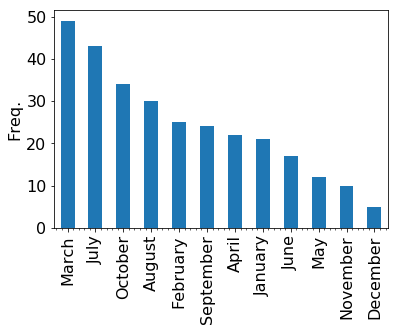

In [14]:
ax = df.datetime.dt.month_name().value_counts().plot(kind='bar')
ax.set_ylabel('Freq.');

[Back to Contents](#TOP)

<a id=hplcfluo></a>
### Consolidate hplc/fluo chlorophyll data
$\ \ \ \Rightarrow$ Merge hplc/fluo columns<br>
$\ \ \ \Rightarrow$ Add hplc flag column

In [15]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [16]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

In [17]:
# fill consolidated chlor_a column with chl_a (hplc) when possible, chl (fluo) otherwise
df['chlor_a'] = df.apply(fill_chl, axis=1)

In [18]:
# Flag chlor_a measurement type; hplc/fluo 
df['is_hplc'] = np.isfinite(df.chl_a)

In [19]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
chl        262 non-null float64
chl_a      33 non-null float64
chlor_a    292 non-null float64
dtypes: float64(3)
memory usage: 6.9 KB


[Back to Contents](#TOP)

###  Deal with negative Rrs values

In [20]:
# assign Nan to nonpositive sat. Rrs
sat_cols = df.filter(regex='sat_rrs', axis=1).columns

In [21]:
for col in sat_cols:
    df.loc[df[col]<=0, col] = np.NaN

[Back to Contents](#TOP)


# <u>Overview</u>
1. Reproducible Pre-processing
    1. ~~[Loading & Cleaning Data](#load)~~
    2. [<font color=red>Exogenous Feature Transformations](#exo)</font>
    3. [Data Splitting into Train/Test Sets](#split)
    4. [Endogenous Data Transformation](#endo)
    5. [Preserving the Pre-Processing Pipeline](#pickle)
    
2. Probabilistic Programming

<a id=exo></a>
### B. Exogenous Feature Transformations

$\ \ \ \Rightarrow$ Transformations independent of dataset statistical properties<br>
$\ \ \ \Rightarrow$ Log-transform<br>
$\ \ \ \Rightarrow$ Band ratio transformation<br>
$\ \ \ \Rightarrow$ Sub-grouping

[Back to Contents](#TOP)

<a id=log></a>
### Log-transform

In [22]:
# Log-transform Rrs Data
for col in sat_cols:
    df[f'log_{col}'] = np.log10(df[col])

In [23]:
# Log-transform Chl Data
df['log_chlor_a'] = np.log10(df.chlor_a)

In [24]:
df.filter(regex='(rrs|chlor_a)', axis=1).head(2)

,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,chlor_a,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,log_chlor_a
0,0.00239,0.00288,0.00345,0.00297,0.00217,0.00026,0.401,-2.621602,-2.540608,-2.462181,-2.527244,-2.663540,-3.585027,-0.396856
1,0.00572,0.00592,0.00494,0.00348,0.00191,0.00018,0.091,-2.242604,-2.227678,-2.306273,-2.458421,-2.718967,-3.744727,-1.040959


[Back to Contents](#TOP)

#### b. Blue-green ratio

* similar to OC4 variable but inverse
* not polynomial
* takes into account dominant blue band
$$\large{X=log_{10}\left(\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}\right)}$$

In [31]:
blue_band_cols = ['log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510']
df['log_maxBlue'] = df[blue_band_cols].max(axis=1)

In [32]:
df['green2MaxBlue'] = df.log_sat_rrs555 - df.log_maxBlue

#### c. Sub-grouping

In [33]:
df['maxBlueID'] = df[blue_band_cols].idxmax(axis=1)
df['maxBlueID'] = df.maxBlueID.str.extract('(rrs[0-9]+)'
                                          ).iloc[:, 0].str.capitalize()

In [37]:
maxBlueCat = pd.CategoricalDtype(categories=np.sort(df.maxBlueID.unique()),
                                 ordered=True)
df['maxBlueIdx'] = df.maxBlueID.astype(maxBlueCat).cat.codes

In [38]:
df[blue_band_cols + ['log_maxBlue', 'maxBlueID', 
                     'maxBlueIdx', 'green2MaxBlue']].head()

,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_maxBlue,maxBlueID,maxBlueIdx,green2MaxBlue
0,-2.540608,-2.462181,-2.527244,-2.462181,Rrs490,1,-0.201359
1,-2.227678,-2.306273,-2.458421,-2.227678,Rrs443,0,-0.491288
2,-2.073143,-2.204120,-2.425969,-2.073143,Rrs443,0,-0.701547
3,-2.910095,-2.752027,-2.714443,-2.714443,Rrs510,2,0.006699
4,-2.903090,-2.744727,-2.703335,-2.703335,Rrs510,2,0.002188


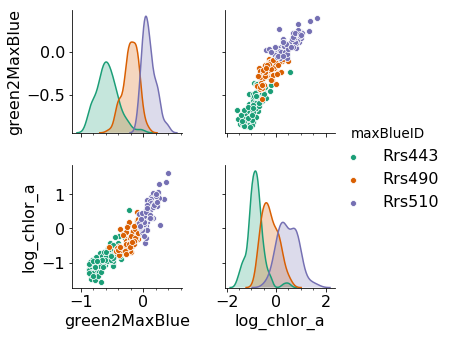

In [41]:
sb.pairplot(df, vars=['green2MaxBlue', 'log_chlor_a'], hue='maxBlueID',
            hue_order=['Rrs443', 'Rrs490', 'Rrs510'], palette='Dark2');
f = pl.gcf()
f.savefig('./resources/pairplot.png', dpi=300)

<center><img src='./resources/pairplot.png?:1'/></center>

[Back to Contents](#TOP)


# <u>Overview</u>
1. Reproducible Pre-processing
    1. ~~[Loading & Cleaning Data](#load)~~
    2. ~~[Exogenous Feature Transformations](#exo)~~
    3. [<font color=red>Data Splitting into Train/Test Sets</font>](#split)
        <br>$\rightarrow$ PanDaS
        <br>$\rightarrow$ Scikit-learn
    4. [Endogenous Data Transformation](#endo)
    5. [Preserving the Pre-Processing Pipeline](#pickle)
    
    
2. Probabilistic Programming

<a id=split></a>
### C. Splitting Data into Train/Test Sets

$\ \ \ \Rightarrow$ Extract relevant subset

$\ \ \ \Rightarrow$ Split into train/test sets

<h2>$\ \ \ \Rightarrow$ Extract relevant subset</h2>

In [43]:
df_extr = df[['datetime', 'green2MaxBlue', 'maxBlueID', 'maxBlueIdx', 'log_chlor_a']]
df_extr.head()

,datetime,green2MaxBlue,maxBlueID,maxBlueIdx,log_chlor_a
0,1997-10-07 09:41:00,-0.201359,Rrs490,1,-0.396856
1,1997-10-11 09:32:00,-0.491288,Rrs443,0,-1.040959
2,1997-09-27 11:29:00,-0.701547,Rrs443,0,-0.801343
3,1998-05-16 08:30:00,0.006699,Rrs510,2,0.420995
4,1998-05-16 09:16:00,0.002188,Rrs510,2,0.401228


In [44]:
X = df_extr.iloc[:, :-1]
y = df_extr.loc[:, ['log_chlor_a']] 

<h2>$\ \ \ \Rightarrow$ Split into train/test sets</h2>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    stratify=X.maxBlueID)

In [47]:
X.maxBlueID.value_counts(normalize=True)*100

Rrs443    44.520548
Rrs490    30.479452
Rrs510    25.000000
Name: maxBlueID, dtype: float64

In [48]:
X_train.maxBlueID.value_counts(normalize=True)*100

Rrs443    44.354839
Rrs490    30.645161
Rrs510    25.000000
Name: maxBlueID, dtype: float64

In [49]:
X_train.head(2)

,datetime,green2MaxBlue,maxBlueID,maxBlueIdx
216,1999-01-29 14:33:00,-0.233493,Rrs490,1
242,2000-08-22 14:30:00,0.002292,Rrs510,2


[Back to Contents](#TOP)


# <u>Overview</u>
1. Reproducible Pre-processing
    1. ~~[Loading & Cleaning Data](#load)~~
    2. ~~[Exogenous Feature Transformations](#exo)~~
    3. ~~[Data Splitting into Train/Test Sets](#split)~~
    4. [<font color=red>Endogenous Data Transformation</font>](#endo)
        <br>$\rightarrow$ PanDaS
        <br>$\rightarrow$ Scikit-learn
    5. [Preserving the Pre-Processing Pipeline](#pickle)
    
    
2. Probabilistic Programming

<a id=endo> </a>

### D. Endogenous Feature Transformation
$\ \ \ \Rightarrow$ Transformation dependent on data statistical properties 
<br>$\ \ \ \Rightarrow$ Parameterized ONCE with training set
<br>$\ \ \ \Rightarrow$ Parameterization must be preseved for future data

<br>$\ \ \ \Rightarrow$ Standardization
<br>$\ \ \ \Rightarrow$ PCA (not shown here)

Standardization
* For each feature $i$, most often refers to $$\frac{X_i - mean(X_i)}{std(X_i)}$$
* generally good modeling practice
* helps putting different variables on comparable scale
* helps relate input to output in terms of z-score

In [50]:
# Instantiate scaler
sc_X = StandardScaler()
sc_y = StandardScaler()

In [51]:
# don't standardize datetime, maxBlueID, maxBlueIdx columns
X_train_s_array = sc_X.fit_transform(X_train.iloc[:, 1:-2]) 
y_train_s_array = sc_y.fit_transform(y_train)

In [55]:
X_test_s_array = sc_X.transform(X_test.iloc[:, 1:-2])
y_test_s_array = sc_y.transform(y_test)

In [52]:
# make new dataframe with standardized data using same index as before to retain link to original observations
X_train_s = pd.DataFrame(X_train_s_array, index=X_train.index,
                        columns=[f'{col}_s' for col in X_train.iloc[:, 1:-2].columns])
X_train_s = X_train[['datetime', 'maxBlueID',
                     'maxBlueIdx']].merge(X_train_s, 
                                          how='outer',
                                          left_index=True, 
                                          right_index=True)
y_train_s = pd.DataFrame(y_train_s_array, 
                         columns=[f'{col}_s' 
                                  for col in y_train.columns],
                         index=y_train.index)

In [53]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


In [54]:
y_train_s.head()

,log_chlor_a_s
216,0.831818
242,1.082246
278,2.042186
141,-0.986848
221,-0.200597


In [56]:
# make new dataframe with standardized data using same index as before to retain link to original observations
X_test_s = pd.DataFrame(X_test_s_array, index=X_test.index,
                        columns=[f'{col}_s' for col in X_test.iloc[:, 1:-2].columns])
X_test_s = X_test[['datetime', 'maxBlueID',
                   'maxBlueIdx']].merge(X_test_s, 
                                        how='outer', 
                                        left_index=True, 
                                        right_index=True)
y_test_s = pd.DataFrame(y_test_s_array, 
                        columns=[f'{col}_s' 
                                 for col in y_test.columns], 
                        index=y_test.index)

[Back to Contents](#TOP)


# <u>Overview</u>
1. Reproducible Pre-processing
    1. ~~[Loading & Cleaning Data](#load)~~
    2. ~~[Exogenous Feature Transformations](#exo)~~
    3. ~~[Data Splitting into Train/Test Sets](#split)~~
    4. ~~[Endogenous Data Transformation](#endo)~~
    5. [<font color=red>Preserving the Pre-Processing Pipeline</font>](#pickle)
        <br>$\rightarrow$ pickle
    
    
2. Probabilistic Programming

<a id='picklepreprocess'> </a>

### E. Pickling the pipeline

$\ \ \ \Rightarrow$ use python dictionaries for easy reference
<br>$\ \ \ \Rightarrow$ pickle training & testing sets
<br>$\ \ \ \Rightarrow$ pickle transformers

In [57]:
train_dict = dict(X=X_train, 
                  X_s=X_train_s,
                  y=y_train, 
                  y_s=y_train_s)

In [58]:
test_dict = dict(X=X_test,
                 X_s=X_test_s,
                 y=y_test,
                 y_s=y_test_s)

In [59]:
transformers_dict = dict(X_scaler=sc_X,
                         y_scaler=sc_y,)

In [60]:
preprocess_dict = dict(raw_data=df,
                       training=train_dict,
                       testing=test_dict,
                       transformers=transformers_dict)

In [61]:
with open('./preprocess_dicts.pkl', 'wb') as fb:
    pickle.dump(preprocess_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
print(f"{os.path.getsize('./preprocess_dicts.pkl')/1000}kB")

443.438kB



# <u>Overview</u>
1. Reproducible Pre-processing
    1. ~~[Loading & Cleaning Data](#load)~~
    2. ~~[Exogenous Feature Transformations](#exo)~~
    3. ~~[Data Splitting into Train/Test Sets](#split)~~
    4. ~~[Endogenous Data Transformation](#endo)~~
    5. ~~[<font color=red>Preserving the Pre-Processing Pipeline</font>](#pickle)~~
    
    
2. Probabilistic Programming

<a id=overview></a>
# <u>Overview</u>
1. ~~Reproducible Pre-processing~~

    
2. Probabilistic Programming
    1. <font color=red>A Quick Primer</font>
    2. Model Development: Approximating Data Generating Process
    3. Priors for Context-Aware Models
    4. Fitting Data, Model Evaluation, Model Comparison
    5. Conclusion

[Back to Contents](#TOP)

### A. A Quick Primer
<br><br>

Joint Probability:
$$P(A,B) = P(A|B) \times P(B) = P(B|A) \times P(B)$$

Yields Bayes Theorem:
$$P(A|B) = \frac{P(B|A)\times P(B)}{P(A)}$$

From Bayes to Probabilistic Programming:


<br>$\ \ \ \rightarrow$ Goal approximate the process that generates observations of interest
<br>$\ \ \ \rightarrow$ postulate model(s, preferably) with set of parameters $H$
<br>$\ \ \ \rightarrow$ include background knowledge about process through formulation of $H$
<br>$\ \ \ \rightarrow$ collect some data $D$
<br>$\ \ \ \rightarrow$ use Bayes to find likeliest values of $H$:
$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$<br>

In practice: 
$$P(H|D) \propto P(D|H)P(H)$$

* P(H): prior on H $\Rightarrow$ quantify of background information
* P(D|H): likelihood of D given H
* P(H|D): probability of H given D $\Rightarrow$ what we're after
* Fitting is done by sampling rather than optimization

<a id=overview></a>
# <u>Overview</u>
1. ~~Reproducible Pre-processing~~

    
2. ~~Probabilistic Programming~~
    1. ~~A Quick Primer~~
    2. <font color=red>Model Development: Approximating the Data Generating Process</font>
    3. Priors for Context-Aware Models
    4. Fitting Data, Model Evaluation, Model Comparison
    5. Conclusion

### B. Model Development: Approximating the Data Generating Process

In [151]:
import pickle

import numpy as np
from scipy.stats import norm
import pandas as pd
import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb

In [3]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [4]:
with open('./preprocess_dicts.pkl', 'rb') as fb:
    preproc_dict = pickle.load(fb)

In [5]:
X_train_s = preproc_dict['training']['X_s']
X_test_s = preproc_dict['testing']['X_s']
y_train_s = preproc_dict['training']['y_s']
y_test_s = preproc_dict['testing']['y_s']

In [6]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


In [7]:
with pm.Model() as m_pooled_naive:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 5) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

In [8]:
m_pooled_naive_graph = pm.model_to_graphviz(m_pooled_naive)
m_pooled_naive.format='png'
m_pooled_naive_graph.render(filename='m_pooled_naive_graph', directory='./resources/', view=False);

<center><img src='./resources/m_pooled_naive_graph.png?:0' width=700 /></center>

[Back to Contents](#TOP)

<a id=overview></a>
# <u>Overview</u>
1. ~~Reproducible Pre-processing~~

    
2. ~~Probabilistic Programming~~
    1. ~~A Quick Primer~~
    2. ~~Model Development: Approximating the Data Generating Process~~
    3. <font color=red>Priors for Context-Aware Models</font>
    4. Fitting Data, Model Evaluation, Model Comparison
    5. Conclusion

<a id='priors'></a>
### C. Priors for Context-Aware Models

In [9]:
def eval_priors(model, y_, fpath, ylim=(-5, 5)):
    # Sample parameters and simulate predictor from model priors
    # Sample parameters
    priors = pm.sample_prior_predictive(model=model, vars=['α', 'β', 'log_chl_s'])
    β_prior = priors['β'].reshape(-1, 1)
    α_prior = priors['α'].reshape(-1, 1)
    log_chl_prior = priors['log_chl_s']
    
    # Create dummy variable
    x_dummy = np.linspace(-3., 3., num=50).reshape(1, -1)
    # Simulate log chl from model priors
    log_chl_lines = α_prior + β_prior * x_dummy
    f, ax = pl.subplots(ncols=2, figsize=(12, 4))
    for i in range(500):
        ax[0].plot(x_dummy.T, log_chl_lines[i], alpha=0.03, color='k')
    ax[0].set_ylim(ylim);
    ax[0]. set_xlabel(r'$\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}$, standardized')
    ax[0].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].hist(priors['log_chl_s'].flatten(), density=True, alpha=0.3, bins=100,
               orientation='horizontal', label='prior');
    ax[1].set_ylim(ylim)
    ax[1].set_xticklabels([])
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].set_xlabel(r'$Freq.$')
    ax2 = ax[1].twiny()
    ax2.hist(y_.values, color='k', density=True, alpha=0.5, bins=20,
             orientation='horizontal', label='observed');
    ax2.set_xticklabels([])
    ax2.legend(loc='lower right')
    f.tight_layout()
    f.savefig(fpath, dpi=300)

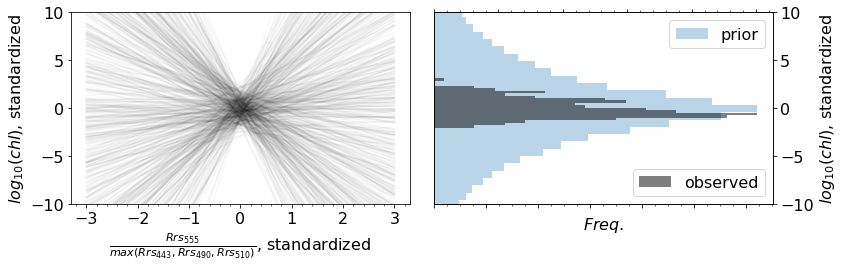

In [114]:
eval_priors(m_pooled_naive, y_=y_train_s.log_chlor_a_s, 
            fpath='./resources/priors_predictive_pooled_naive.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_naive.png?:0'/></center>

$\Rightarrow$ Nonsensical log(chl) values $\rightarrow$ Priors too naive; need adjustment<br>
$\Rightarrow$ Informative priors $\rightarrow$ Incorportation of background knowledge into model

In [10]:
with pm.Model() as m_pooled_wk_informative:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 1) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

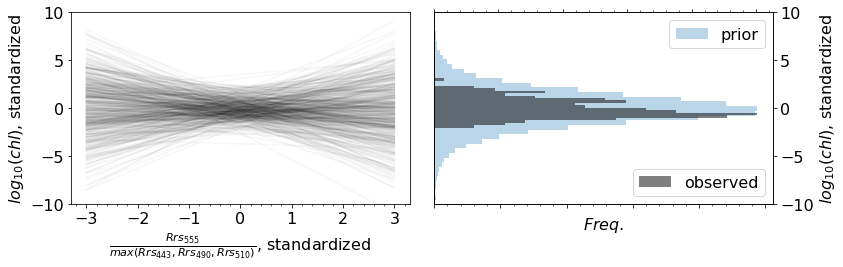

In [118]:
eval_priors(m_pooled_wk_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_wk_informative.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_wk_informative.png?:2'></center>

In [11]:
with pm.Model() as m_pooled_informative:
    α = pm.Normal('α', 0, 0.5) # prior on intercept
    β = pm.Normal('β', 0, 0.2) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + β * X_train_s.green2MaxBlue_s.values # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

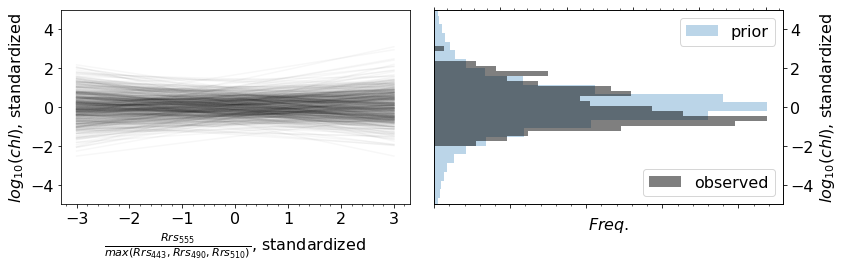

In [120]:
eval_priors(m_pooled_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_informative.png', ylim=(-5, 5))

<center><img src='./resources/priors_predictive_pooled_informative.png?:3'/></center>

<a id=overview></a>
# <u>Overview</u>
1. ~~Reproducible Pre-processing~~

    
2. ~~Probabilistic Programming~~
    1. ~~A Quick Primer~~
    2. ~~Model Development: Approximating the Data Generating Process~~
    3. ~~Priors for Context-Aware Models~~
    4. <font color=red>Fitting Data, Model Evaluation, Model Comparison</font>
    5. Conclusion

In [18]:
with m_pooled_informative:
    trace_pooled_informative = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1936.25draws/s]


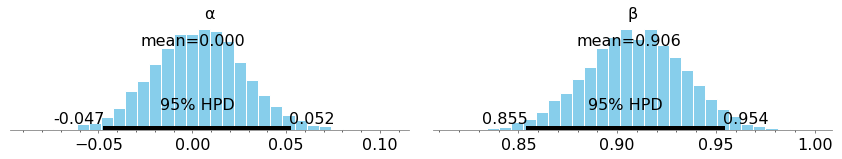

In [19]:
pm.plot_posterior(trace=trace_pooled_informative, varnames=['α', 'β']);

In [178]:
ppc = pm.sample_posterior_predictive(trace_pooled_informative,
                                     model=m_pooled_informative)['log_chl_s']
ppc_mean = ppc.mean(axis=0)
hpd = pm.hpd(ppc)

100%|██████████| 8000/8000 [00:04<00:00, 1718.59it/s]


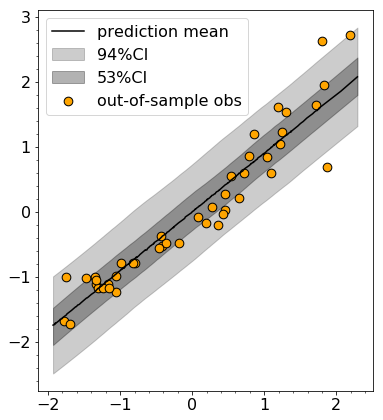

In [180]:
x_idx = X_train_s.green2MaxBlue_s.argsort()

f, ax = pl.subplots(figsize=(6, 7))
ax.plot(X_train_s.green2MaxBlue_s.values[x_idx],ppc_mean[x_idx], color='k',
        label='prediction mean')
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.2, 
                                                             color='k',
                                                             label='94%CI'),
            credible_interval=0.94, ax=ax)
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.3, 
                                                             color='k',
                                                             label='53%CI'),
            credible_interval=0.53, ax=ax)
ax.scatter(X_test_s.green2MaxBlue_s.values, y_test_s, color='orange', edgecolor='k',
           label='out-of-sample obs', s=75)
ax.legend(loc='upper left')
f.savefig('./resources/ppc_informative.png', dpi=300)

<img src='./resources/ppc_informative.png?:0' width=500 />

<center><img src='./resources/pairplot.png?:1' width=800/></center>

In [147]:
n_blue_groups = X_train_s.maxBlueIdx.unique().size
with pm.Model() as m_unpooled_informative:
    # prior on intercept
    α = pm.Normal('α', 0, 0.5, shape=n_blue_groups) 
    # prior on slopes
    β = pm.Normal('β', 0, 0.2, shape=n_blue_groups) 
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values,] + β[X_train_s.maxBlueIdx.values] * X_train_s.green2MaxBlue_s.values 
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) 

In [30]:
m_unpooled_informative_graph = pm.model_to_graphviz(m_unpooled_informative)
m_unpooled_informative_graph.format='png'
m_unpooled_informative_graph.render(filename='m_unpooled_informative_graph',
                                    directory='./resources/',
                                    view=False);

<center><img src='./resources/m_unpooled_informative_graph.png?:0' width=700 /></center>

In [148]:
with m_unpooled_informative:
    trace_unpooled_informative = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:19<00:00, 616.51draws/s]


In [44]:
with pm.Model() as m_partially_pooled_informative:
    # prior on intercept
    hyp_α_mean = pm.Normal('hyp_α_mean', mu=0, sd=0.5)
    hyp_α_sd = pm.HalfCauchy('hyp_α_sd', beta=2.5)
    hyp_β_mean = pm.Normal('hyp_β_mean', mu=0, sd=0.2)
    hyp_β_sd = pm.HalfCauchy('hyp_β_sd', beta=2.5)
    # Here, I use an offsetting trick for easiser exploration of the parameter space
    #α_offset = pm.Normal('α_offset', mu=0, sd=1, shape=n_blue_groups)
    #β_offset = pm.Normal('β_offset', mu=0, sd=1, shape=n_blue_groups)
    # prior on intercepts
    α = pm.Normal('α', mu=hyp_α_mean, sd=hyp_α_sd, shape=n_blue_groups) 
    # prior on slopes
    β = pm.Normal('β', mu=hyp_β_mean, sd=hyp_β_sd, shape=n_blue_groups)
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values] + β[X_train_s.maxBlueIdx.values] * X_train_s.green2MaxBlue_s.values 
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) 

In [45]:
m_partially_pooled_informative_graph = pm.model_to_graphviz(m_partially_pooled_informative)
m_partially_pooled_informative_graph.format='png'
m_partially_pooled_informative_graph.render(filename='m_part_pooled_informative_graph',
                                    directory='./resources/',
                                    view=False);

<center><img src='./resources/m_part_pooled_informative_graph.png?:0' width=1200 /></center>

In [47]:
with m_partially_pooled_informative:
    trace_partially_pooled_informative = pm.sample(2000, tune=10000, chains=4,
                                                   nuts_kwargs=(dict(target_accept=0.95)
                                                               ))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α, hyp_β_sd, hyp_β_mean, hyp_α_sd, hyp_α_mean]
Sampling 4 chains: 100%|██████████| 48000/48000 [03:35<00:00, 223.20draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


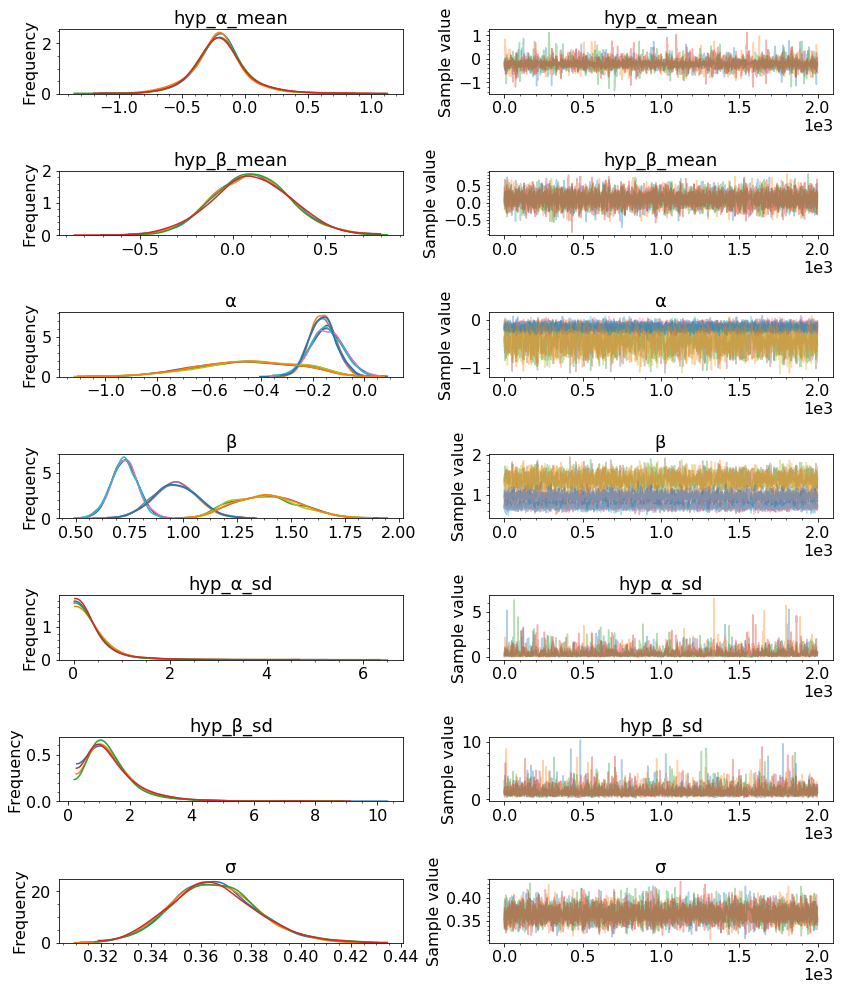

In [48]:
pm.traceplot(trace_partially_pooled_informative);

In [49]:
pm.summary(trace_partially_pooled_informative)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
hyp_α_mean,-0.201644,0.216518,0.003518,-0.631844,0.268982,3494.509349,1.000228
hyp_β_mean,0.100621,0.207639,0.002433,-0.291595,0.529106,6007.777350,0.999773
α__0,-0.146657,0.064801,0.001067,-0.271293,-0.016862,4504.619460,1.000469
α__1,-0.162152,0.051262,0.000610,-0.256866,-0.055456,5589.232658,0.999847
α__2,-0.452496,0.192989,0.003897,-0.823171,-0.111624,2364.878303,1.001426
β__0,0.725385,0.061181,0.000977,0.610690,0.855313,4626.498766,1.000572
β__1,0.962685,0.101201,0.001403,0.755933,1.151075,5228.713734,1.000132
β__2,1.386264,0.150314,0.002924,1.111722,1.670759,2468.061763,1.001179
hyp_α_sd,0.413403,0.453238,0.007910,0.014503,1.218962,2749.187918,1.000600
hyp_β_sd,1.441095,0.888674,0.014214,0.342415,3.099802,4226.740245,1.000184


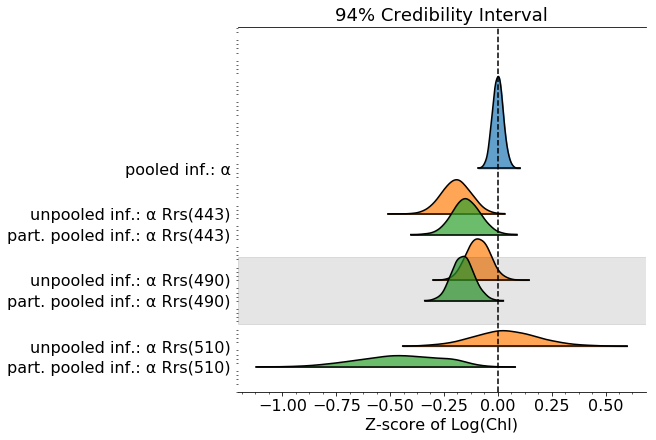

In [90]:
f, axs = ar.plot_forest([trace_pooled_informative,
                         trace_unpooled_informative,
                         trace_partially_pooled_informative],
                        model_names= ['pooled inf.', 'unpooled inf.', 'part. pooled inf.'],
                        var_names=['α'], combined=True,
                        kind='ridgeplot', ridgeplot_overlap=5, ridgeplot_alpha=0.7,
                        colors=['C0', 'C1', 'C2'], figsize=(9,6))
new_labels = []
for txt in ax.yaxis.get_ticklabels():
    st = txt.get_text()
    if 'α 2' in st:
        st = st.replace('2', 'Rrs(510)')
    elif 'α 1' in st:
        st = st.replace('1', 'Rrs(490)')
    elif 'α 0' in st:
        st = st.replace('0', 'Rrs(443)')
    new_labels.append(st)
axs[0].yaxis.set_ticklabels(new_labels)
axs[0].axvline(ls='--', color='k')
axs[0].set_title('94% Credibility Interval')
axs[0].set_xlabel('Z-score of Log(Chl)')
f.savefig('./resources/forest_intercept.png', dpi=300);

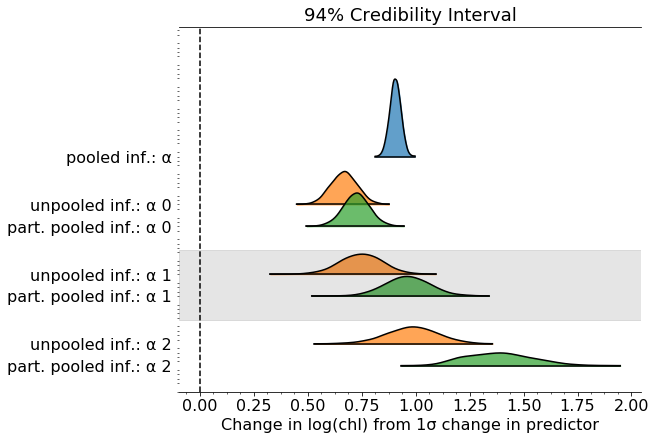

In [95]:
f, axs = ar.plot_forest([trace_pooled_informative,
                         trace_unpooled_informative,
                         trace_partially_pooled_informative],
                        model_names= ['pooled inf.', 'unpooled inf.', 'part. pooled inf.'],
                        var_names=['β'], combined=True,
                        kind='ridgeplot', ridgeplot_overlap=4, ridgeplot_alpha=0.7,
                        colors=['C0', 'C1', 'C2'], figsize=(9,6))
new_labels = []
for txt in ax.yaxis.get_ticklabels():
    st = txt.get_text()
    if 'β 2' in st:
        st = st.replace('2', 'Rrs(510)')
    elif 'β 1' in st:
        st = st.replace('1', 'Rrs(490)')
    elif 'β 0' in st:
        st = st.replace('0', 'Rrs(443)')
    new_labels.append(st)
axs[0].yaxis.set_ticklabels(new_labels)
axs[0].axvline(ls='--', color='k')
axs[0].set_title('94% Credibility Interval')
axs[0].set_xlabel('Change in log(chl) from 1σ change in predictor')
f.savefig('./resources/forest_slopes.png', dpi=300)

/Users/erdemk/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


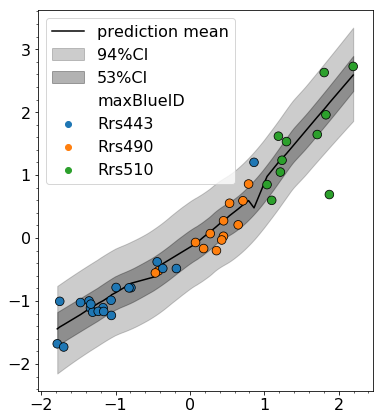

In [175]:
β_post_part_pld_inf = trace_partially_pooled_informative.get_values('β')
α_post_part_pld_inf = trace_partially_pooled_informative.get_values('α')
σ_post_part_pld_inf = trace_partially_pooled_informative.get_values('σ').reshape(-1, 1)

μ_post_1 = α_post_part_pld_inf[:,X_test_s.maxBlueIdx]

μ_post_2 = β_post_part_pld_inf[:, X_test_s.maxBlueIdx] * X_test_s.green2MaxBlue_s.values.reshape(1, -1)

μ_post = μ_post_1 + μ_post_2

μ_post_means = μ_post.mean(axis=0)
ppc_part_pld = norm.rvs(μ_post, scale=σ_post_part_pld_inf)

ppc_mean_part_pld = ppc_part_pld.mean(axis=0)

cols = ['C0', 'C1', 'C2']
col_vec = [cols[i] for i in X_test_s.maxBlueIdx.values]

f, ax = pl.subplots(figsize=(6, 7))
x_idx = X_test_s.green2MaxBlue_s.argsort()
ax.plot(X_test_s.green2MaxBlue_s.values[x_idx],ppc_mean_part_pld[x_idx],
        label='prediction mean', color='k', zorder=0)
ar.plot_hpd(X_test_s.green2MaxBlue_s, ppc_part_pld,
            fill_kwargs=dict(alpha=0.2, color='k', label='94%CI'),
            credible_interval=0.94, ax=ax)
ar.plot_hpd(X_test_s.green2MaxBlue_s, ppc_part_pld,
            fill_kwargs=dict(alpha=0.3, color='k', label='53%CI'),
            credible_interval=0.53, ax=ax,)
#ax.scatter(X_test_s.green2MaxBlue_s.values, y_test_s, color= col_vec, edgecolor='k',
           #label=['out-of-sample obs1', '2', '3'], s=50)#
sb.scatterplot(X_test_s.green2MaxBlue_s.values.flat, y_test_s.values.flat,ax=ax,
               hue=X_test_s.maxBlueID, hue_order=['Rrs443', 'Rrs490', 'Rrs510'],
              palette=cols, zorder=3, edgecolor='k', s=75,
              )
l = ax.legend();
ax.set_label(r'$log_{10}\left(\frac{green}{max(blue)}$')
f.savefig('./resources/ppc_part_pld_inf.png', dpi=300)

<table>
    <td>
        <img src="./resources/ppc_informative.png?:2"  width=500 />
    </td>
    <td>
        <img src="./resources/ppc_part_pld_inf.png?:0" width=500 />
    </td>
</table>

In [198]:
model_dict = dict(models=dict(part_pooled_inf=m_partially_pooled_informative,
                              unpooled_inf=m_unpooled_informative,
                              pooled_inf=m_pooled_informative), 
                  trace=dict(part_pooled_inf=trace_partially_pooled_informative,
                             unpooled_inf=trace_unpooled_informative, 
                             pooled_inf=trace_pooled_informative))

In [199]:
with open('./resources/models_dict.pkl', 'wb') as fb:
    pickle.dump(model_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [181]:
m_pooled_informative.name = 'pooled inf.'
m_unpooled_informative.name = 'unpooled inf'
m_partially_pooled_informative.name = 'part. pooled inf.'

pm.compare({m_pooled_informative: trace_pooled_informative,
            m_unpooled_informative: trace_unpooled_informative,
            m_partially_pooled_informative: trace_partially_pooled_informative})

/Users/erdemk/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/erdemk/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
part. pooled inf.,210.86,7.7,0,0.86,25.92,0,1
unpooled inf,228.16,7.21,17.3,0,26.23,7.53,1
pooled inf.,244.87,2.99,34.01,0.14,21.41,14.54,0


In [183]:
df_loo = pm.compare({m_pooled_informative: trace_pooled_informative,
                     m_unpooled_informative: trace_unpooled_informative,
                     m_partially_pooled_informative: trace_partially_pooled_informative},
                    ic='LOO')

In [184]:
df_loo[['LOO', 'pLOO', 'dLOO', 'weight']]

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
part. pooled inf.,210.93,7.74,0,0.86,25.94,0,0
unpooled inf,228.23,7.25,17.3,0,26.25,7.55,0
pooled inf.,244.87,2.99,33.94,0.14,21.41,14.56,0


<a id=overview></a>
# <u>Overview</u>
1. ~~Reproducible Pre-processing~~

    
2. ~~Probabilistic Programming~~
    1. ~~A Quick Primer~~
    2. ~~Model Development: Approximating the Data Generating Process~~
    3. ~~Priors for Context-Aware Models~~
    4. ~~Fitting Data, Model Evaluation, Model Comparison~~
    5. <font color=red>Conclusion</font>

### E. Conclusion


    * Inclusion of background information provides context
    * Generative model means simulation before and after data collection and fitting
    * Built-in principled uncertainty estimation via probabilistic sampling
    * Natural fit for use with Information Theory
        * model evaluation 
        * model comparison